In [1]:
# pip install entropy-based-binning
# pip install scikit-plot

In [1]:
import warnings
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy as sp
from math import ceil
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis
import phik
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
import graphviz
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot

## Data Understanding:

### Collect initial data

In [2]:
#Importing the csv file
data = pd.read_csv("H2.csv")

### Describe data

In [4]:
#Checking how many entries and variables we have, while analysing its types.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

In [5]:
#Checking the first rows of the dataset, to see if everything is alright.
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


### Data Exploration

In [6]:
#Get some basic statistical information about all the variables.
data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IsCanceled,79330.0,NaN,NaN,NaN,0.41727,0.493111,0.0,0.0,0.0,1.0,1.0
LeadTime,79330.0,NaN,NaN,NaN,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,79330.0,NaN,NaN,NaN,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateMonth,79330,12,August,8983,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrivalDateWeekNumber,79330.0,NaN,NaN,NaN,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,79330.0,NaN,NaN,NaN,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,79330.0,NaN,NaN,NaN,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,79330.0,NaN,NaN,NaN,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
Adults,79330.0,NaN,NaN,NaN,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
Children,79326.0,NaN,NaN,NaN,0.09137,0.372177,0.0,0.0,0.0,0.0,3.0


In [3]:
#Separating the variables into "metric" and "categorical" ones
metric_features=["LeadTime","StaysInWeekendNights", "StaysInWeekNights", "Adults", "Children", "Babies", "PreviousCancellations", "PreviousBookingsNotCanceled", "BookingChanges", "DaysInWaitingList", "ADR", "RequiredCarParkingSpaces", "TotalOfSpecialRequests"]
categorical_features= data.columns.drop(metric_features).to_list()

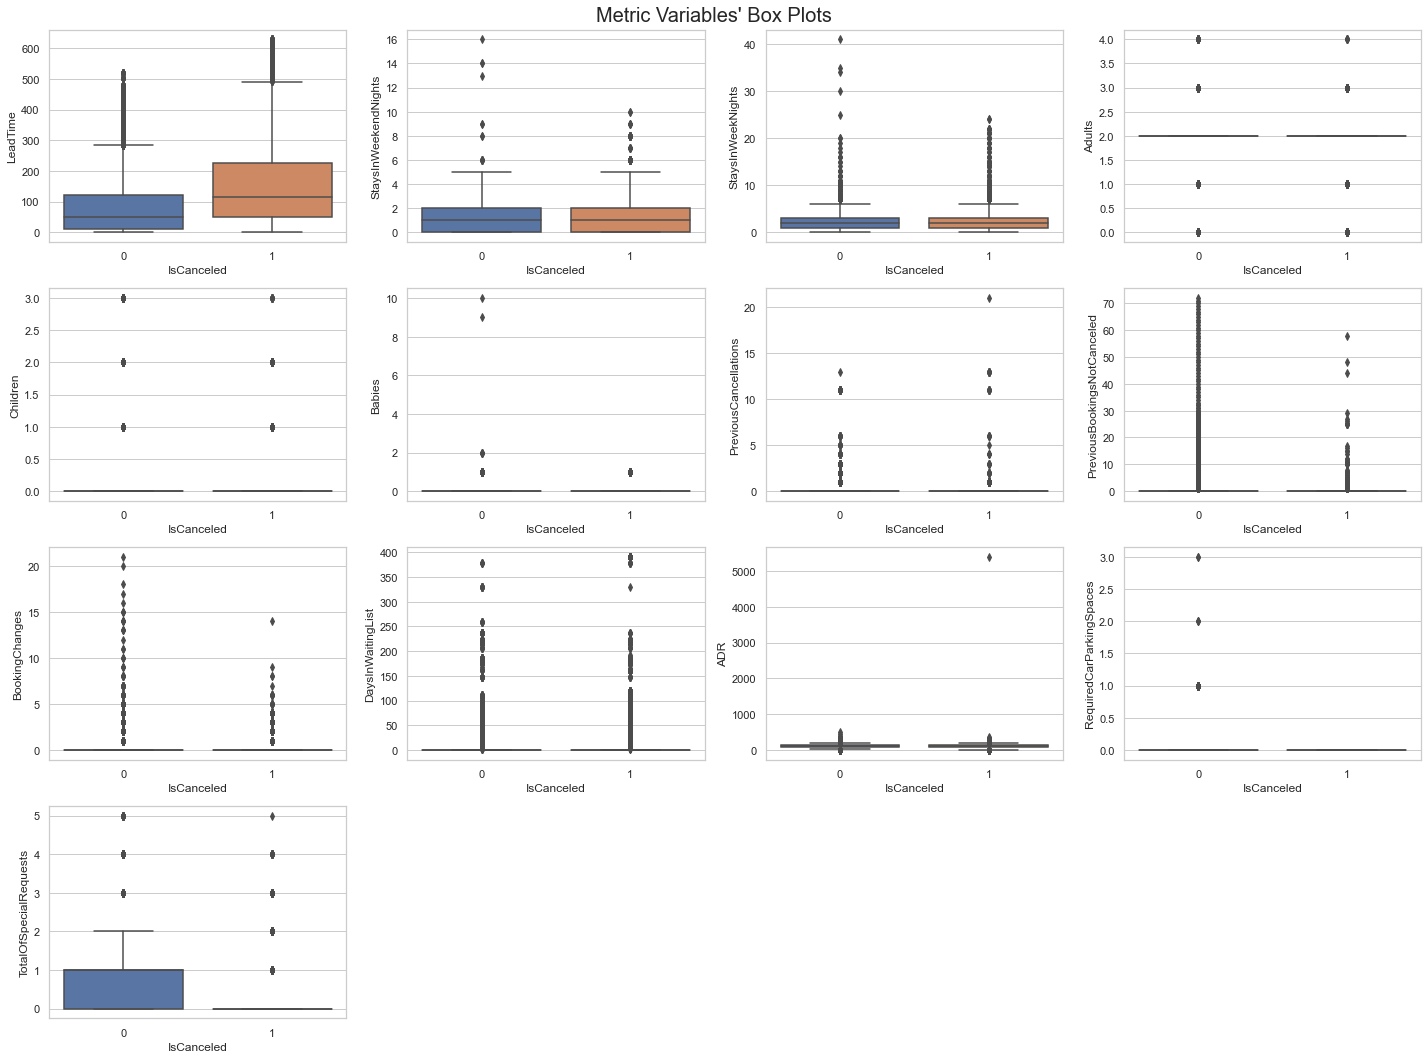

In [8]:
#Plotting boxplots for each metric feature, in order to analyse its distribution, while also making the separation between the observations which have 0 or 1 for the variable IsCanceled

#changing the background
sns.set()
sns.set_style("whitegrid")

#defining the number of plots
fig, axes = plt.subplots(4, 4, figsize=(20, 15))

#plotting each boxplot
for ax, features in zip(axes.flatten(), metric_features):
    sns.boxplot(y=data[features], x=data["IsCanceled"], ax=ax)
    
plt.suptitle("Metric Variables' Box Plots", fontsize=20)

#Adjusting the "visual" aspect of the plots
fig.delaxes(axes[3,1])
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,3])
plt.tight_layout()

plt.show()

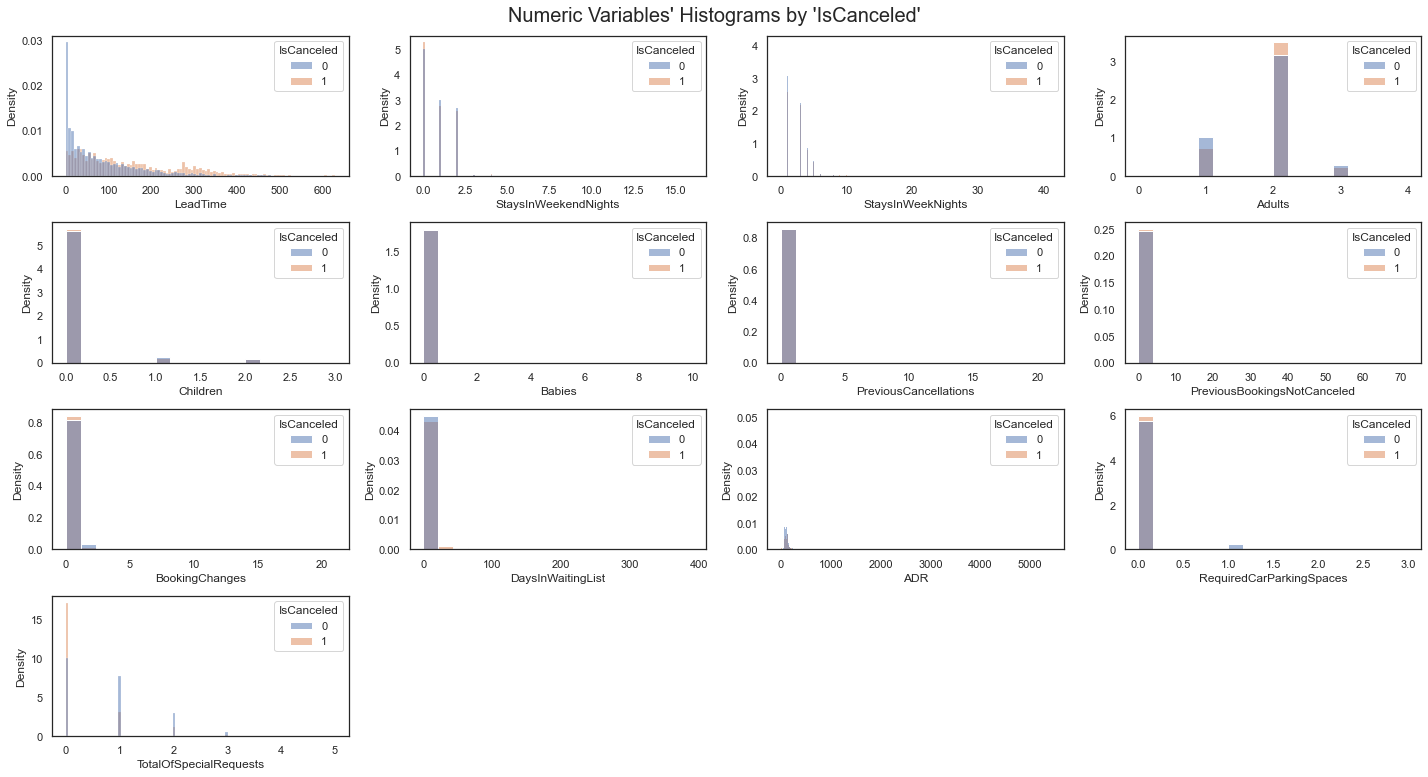

In [9]:
#Plotting histograms for each metric feature, in order to analyse its distribution from another perspective, while also making the separation between the observations which have 0 or 1 for the variable IsCanceled

#Defining the background
sns.set()
sns.set_style("white")

# Creating the needed number of plots
fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(20, 11))

#Plotting each metric feature, using the "hue" to make the separation according to the variable IsCanceled
for ax, feat in zip(axes.flatten(), metric_features):
    sns.histplot(x=data[feat], hue=data['IsCanceled'], stat='density', common_norm=False, ax=ax)
    
#Defining a title
plt.suptitle("Numeric Variables' Histograms by 'IsCanceled'",fontsize=20 )

#Adjusting the "visual" aspect of the plots
fig.delaxes(axes[3,1])
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,3])
plt.tight_layout()

plt.show()

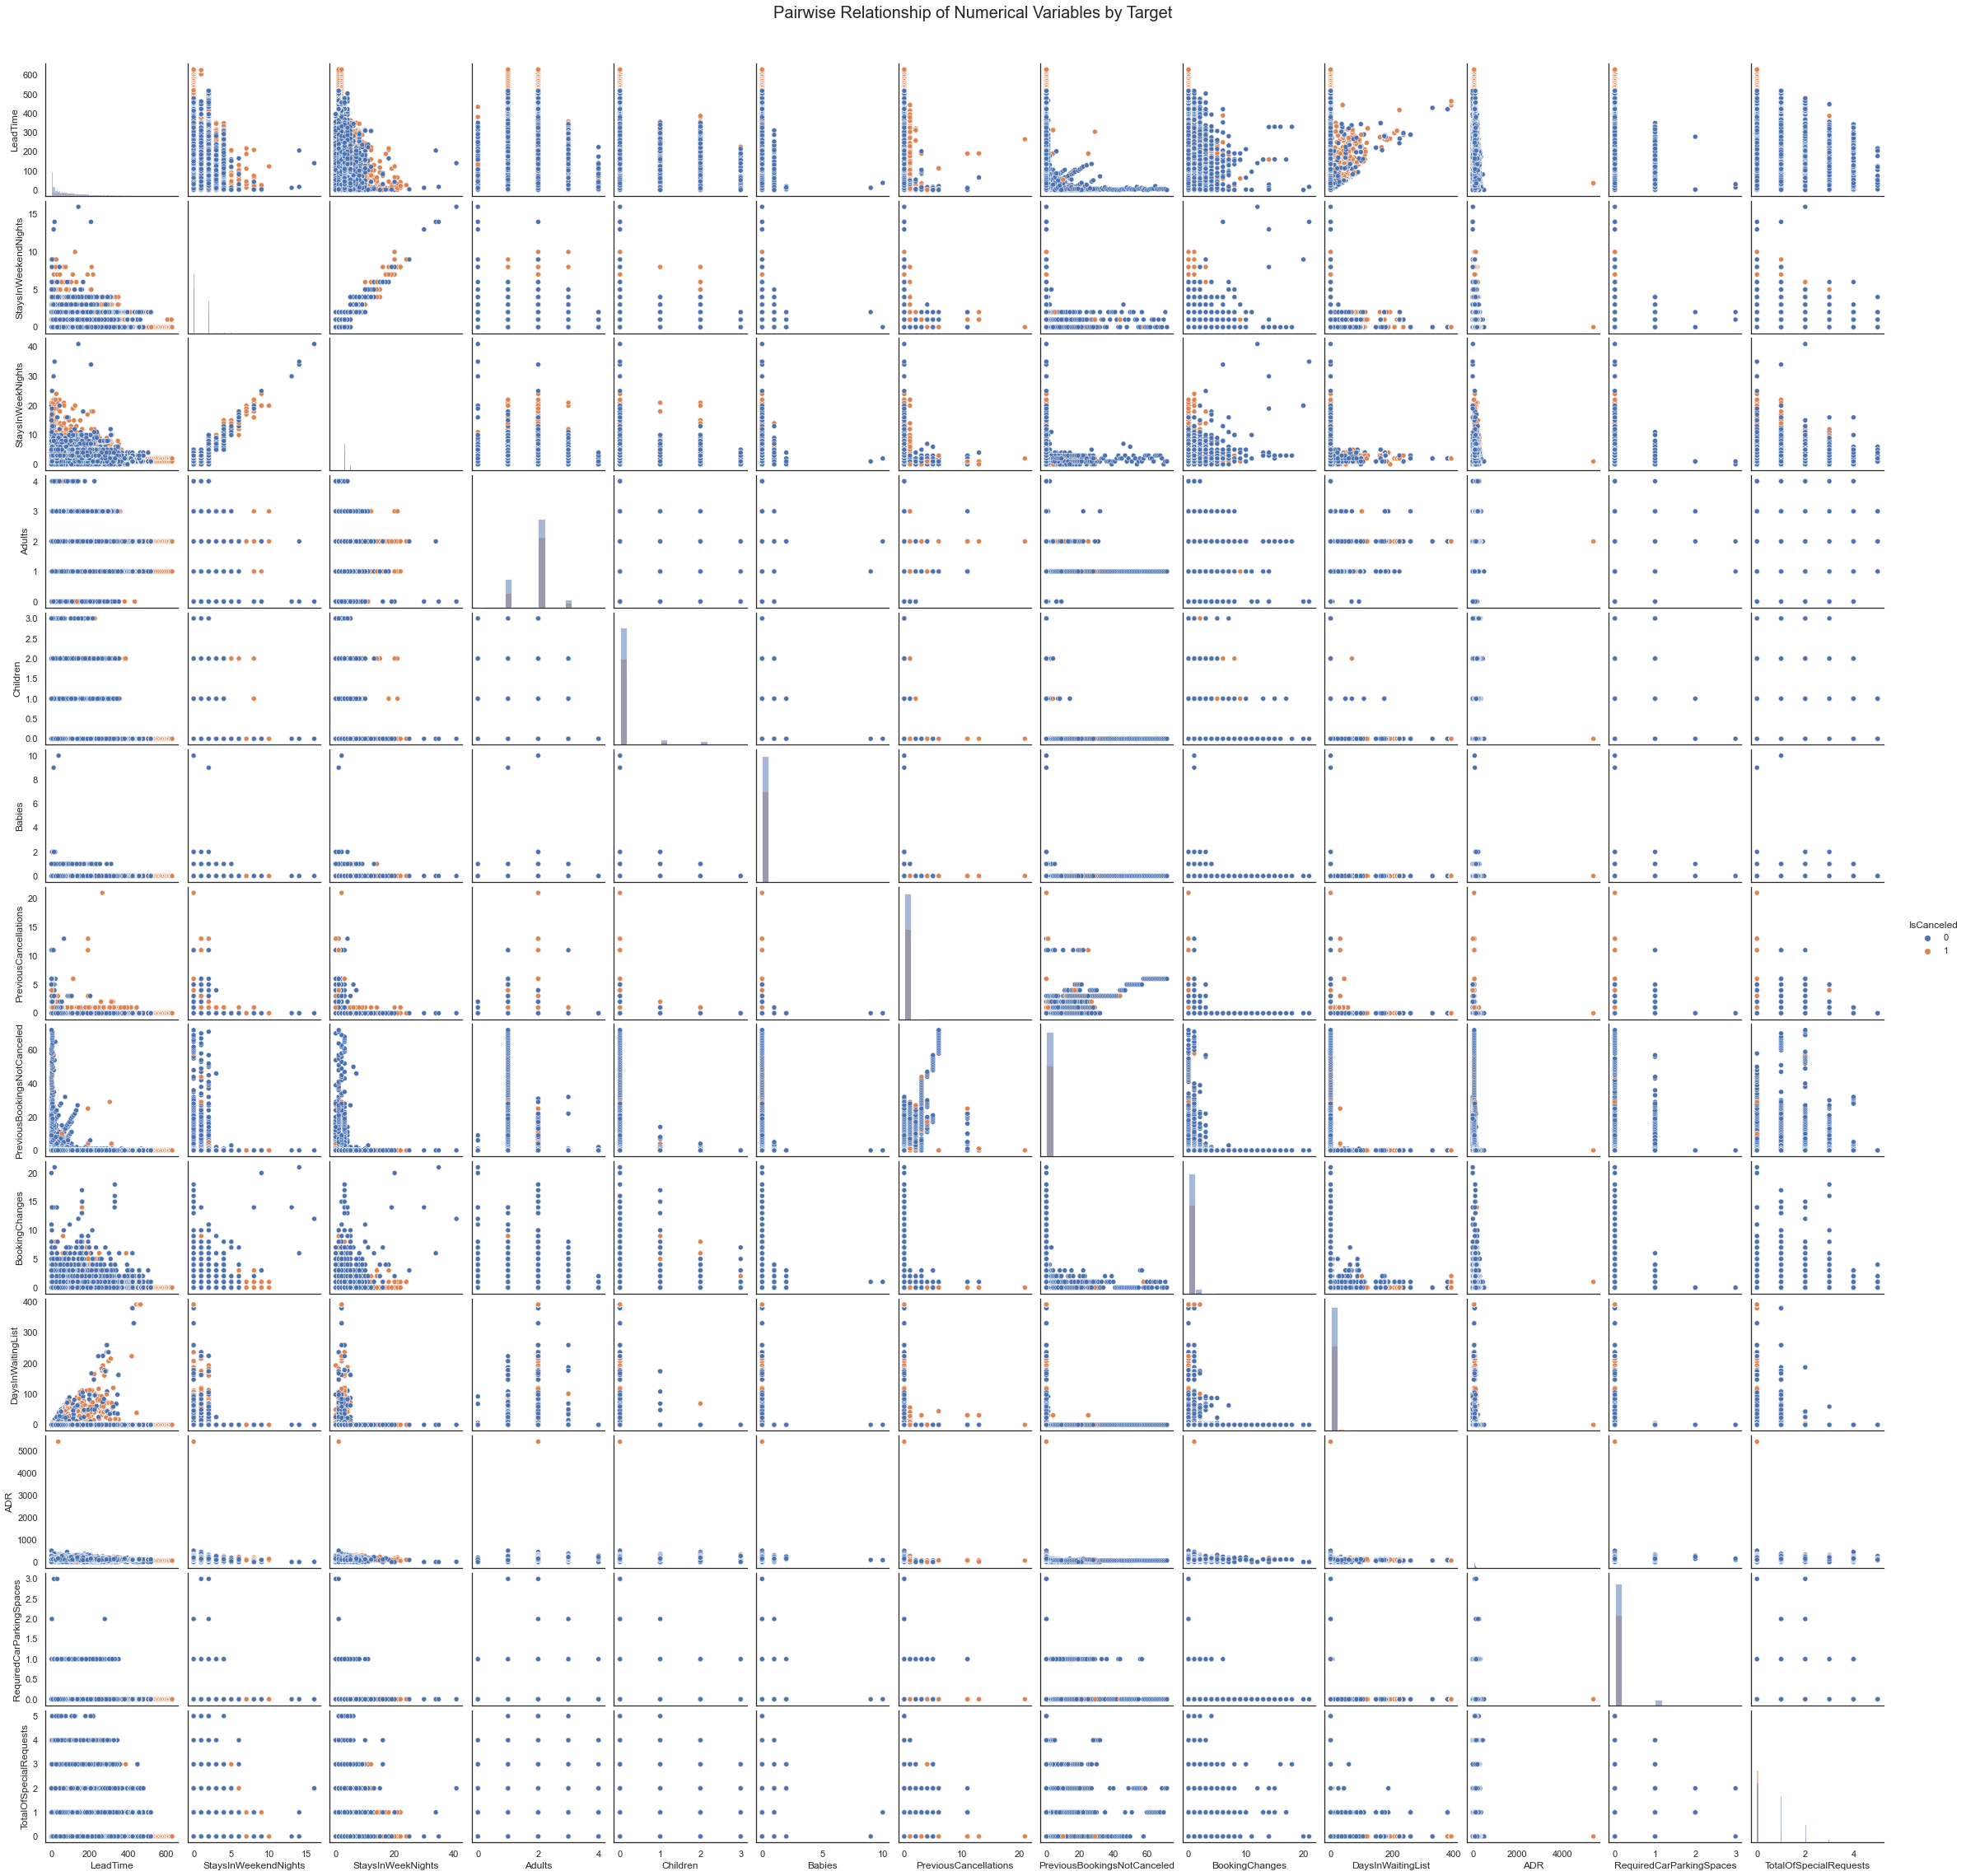

In [10]:
#Analysing the Pairwise Relationship of the metric features

#Setting the background
sns.set()
sns.set_style("white")

#Defining the variables we will use, including the "target" one.
features = metric_features + ['IsCanceled']

#Plotting the data, using "hue" to make the distiction between a customer having 1 or 0 in IsCanceled
sns.pairplot(data=data[features], hue='IsCanceled', diag_kind="hist")

#Defining the title and adjustments
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables by Target", fontsize=20)

plt.show()

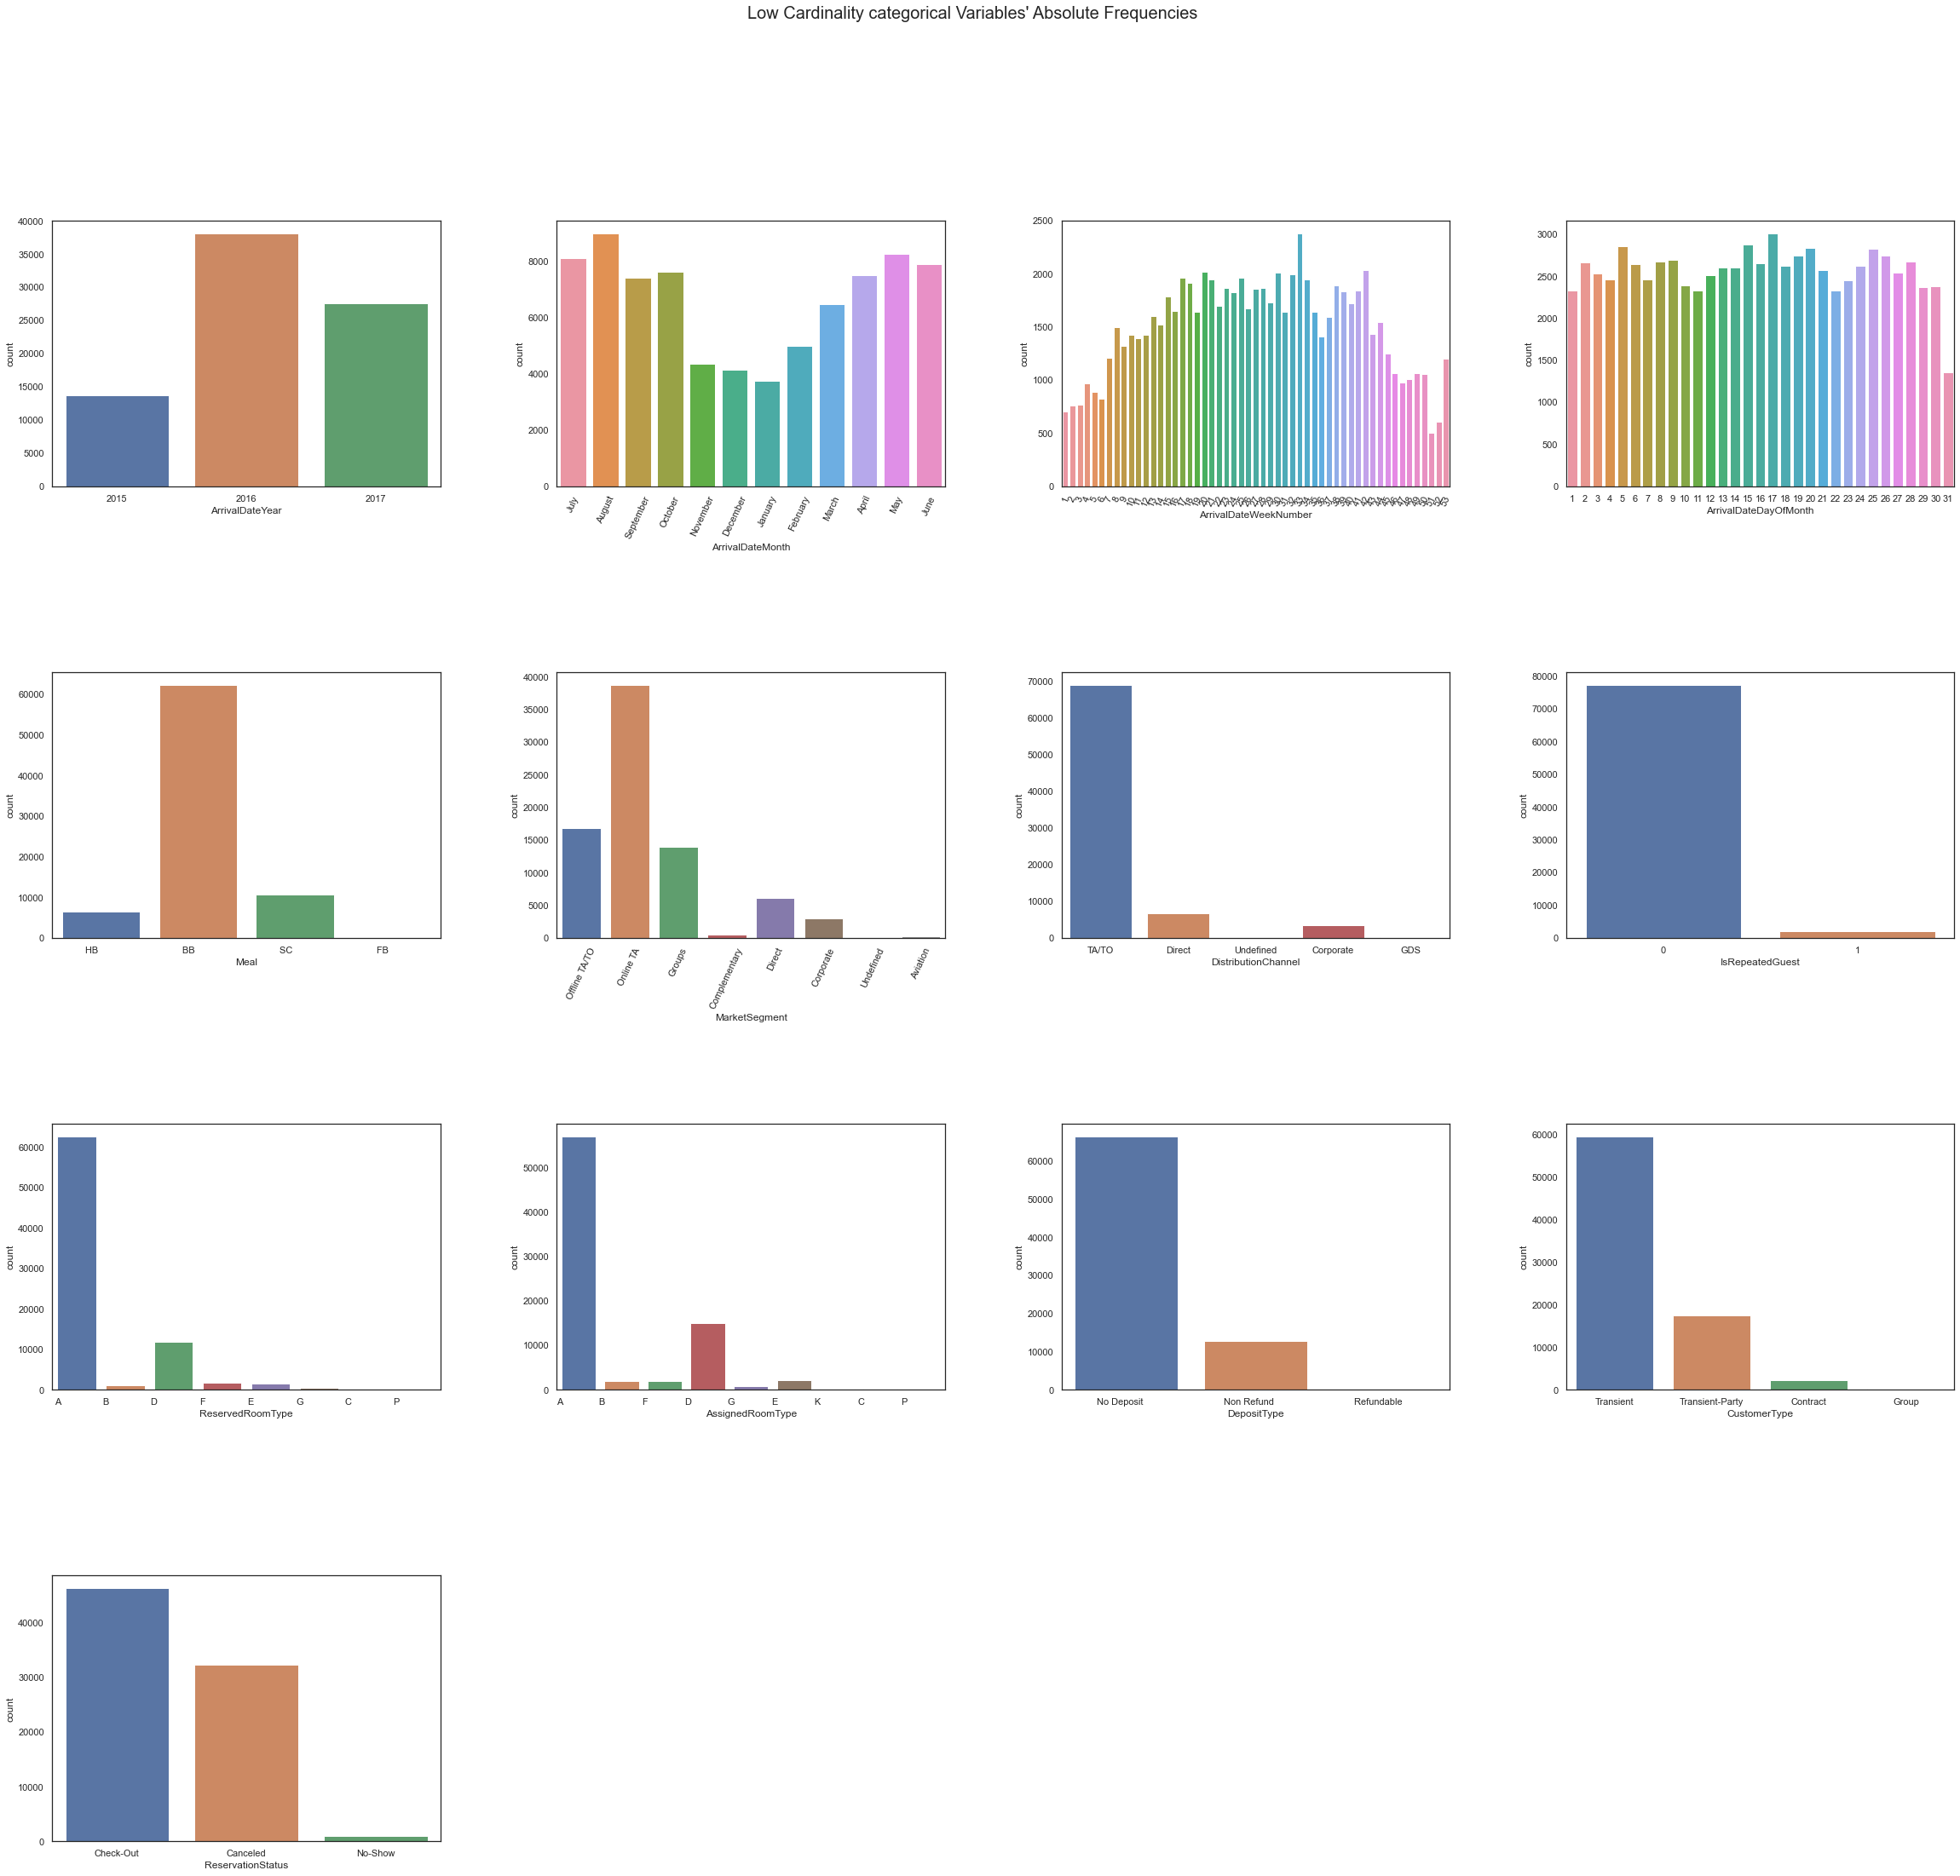

In [11]:
#Plotting barplots as a way to see the distribution of the labels of the categorical variables. 
#Note: We will not plot the ones with higher cardinality, for easiness in the visualization.

#Defining the background
sns.set()
sns.set_style("white")

#specifying the variables we will plot, as mentioned before, making a small adjustment to the categorical_features
features = [i for i in categorical_features if i not in ["ReservationStatusDate","Agent", "Company", "Country", "IsCanceled"]]

#Defining the number of plots
fig, axes = plt.subplots(4, ceil(len(features) / 4), figsize=(40, 35))

#Plotting each plot
for ax, feat in zip(axes.flatten(), features):
    sns.countplot(x=data[feat], ax=ax)

#Defining the title and some layout options
plt.suptitle("Low Cardinality categorical Variables' Absolute Frequencies", fontsize=20)
axes.flatten()[1].tick_params(axis='x', labelrotation = 65)
axes.flatten()[2].tick_params(axis='x', labelrotation = 65)
axes.flatten()[5].tick_params(axis='x', labelrotation = 65)
fig.delaxes(axes[3,1])
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,3])
plt.subplots_adjust(wspace=0.3, hspace=0.7)

plt.show()

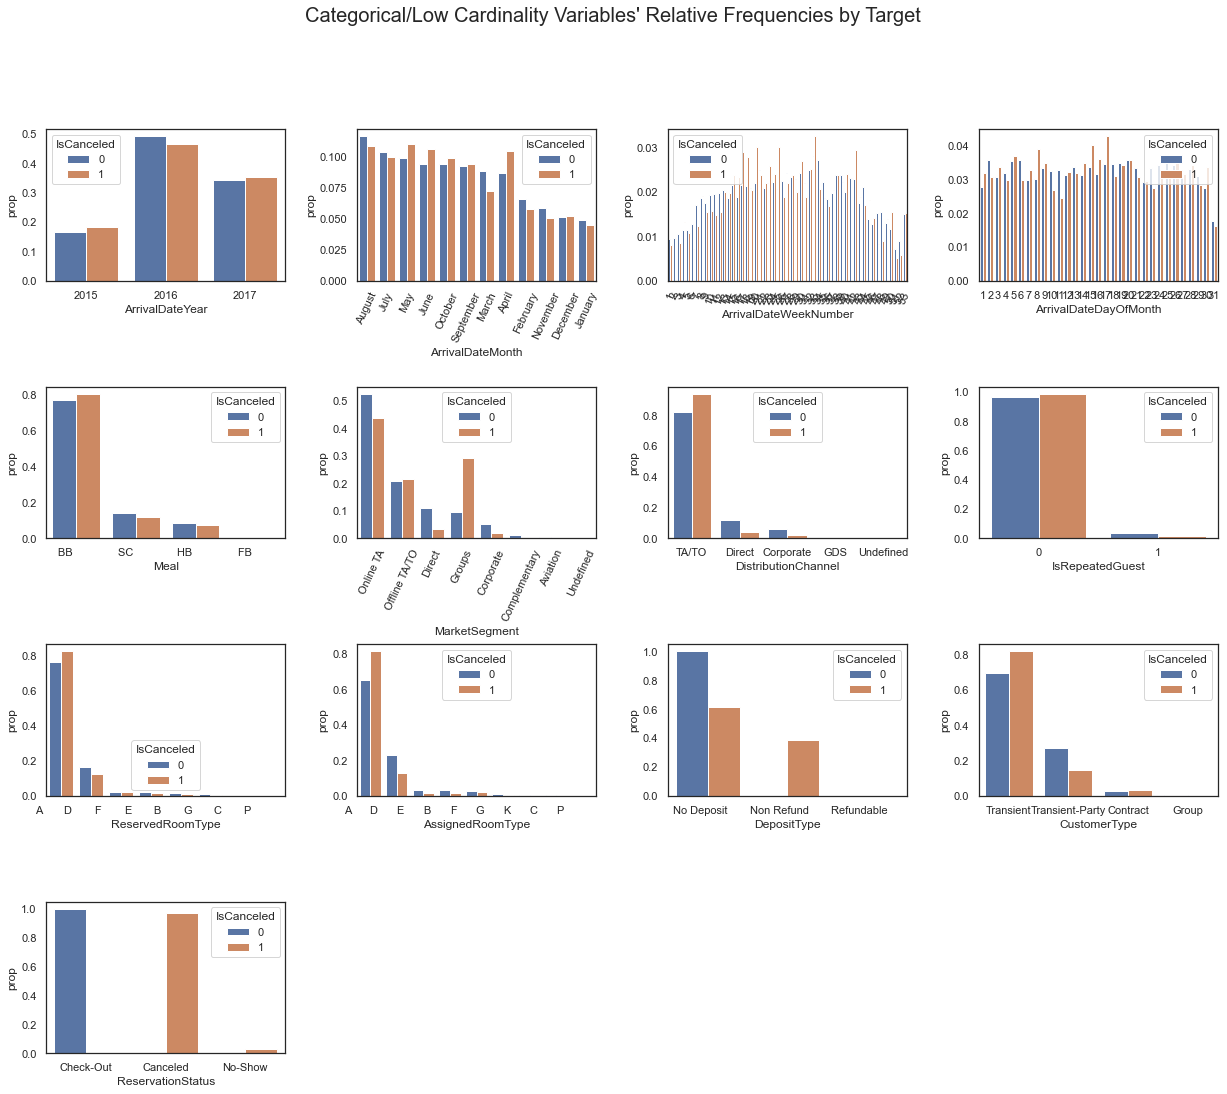

In [12]:
#Going further in the use of the barplots, by adding the "hue" element, separating between a customer having 0 or 1 in the variable "IsCanceled"

#Defining the background
sns.set()
sns.set_style("white")
 
#Once more, defining the variables to use
features = [i for i in categorical_features if i not in ["ReservationStatusDate","Agent", "Company", "Country", "IsCanceled"]]

#choosing teh number of plots
fig, axes = plt.subplots(4, ceil(len(features) / 4), figsize=(21, 17))

#Plotting each barplot
for ax, feat in zip(axes.flatten(), features):
    dt = data.groupby(['IsCanceled'])[feat].value_counts(normalize=True).rename('prop').reset_index()
    sns.barplot(data=dt, x=feat, y='prop', hue='IsCanceled', ax=ax)

#Defining the title
plt.suptitle("Categorical/Low Cardinality Variables' Relative Frequencies by Target", fontsize=20)

#Adjusting the layout
axes.flatten()[-1].remove()
axes.flatten()[1].tick_params(axis='x', labelrotation = 65)
axes.flatten()[2].tick_params(axis='x', labelrotation = 65)
axes.flatten()[5].tick_params(axis='x', labelrotation = 65)
fig.delaxes(axes[3,1])
fig.delaxes(axes[3,2])
plt.subplots_adjust(wspace=0.3, hspace=0.7)

plt.show()

interval columns not set, guessing: ['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', 'IsRepeatedGuest', 'PreviousCancellations', 'PreviousBookingsNotCanceled', 'BookingChanges', 'DaysInWaitingList', 'ADR', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests']


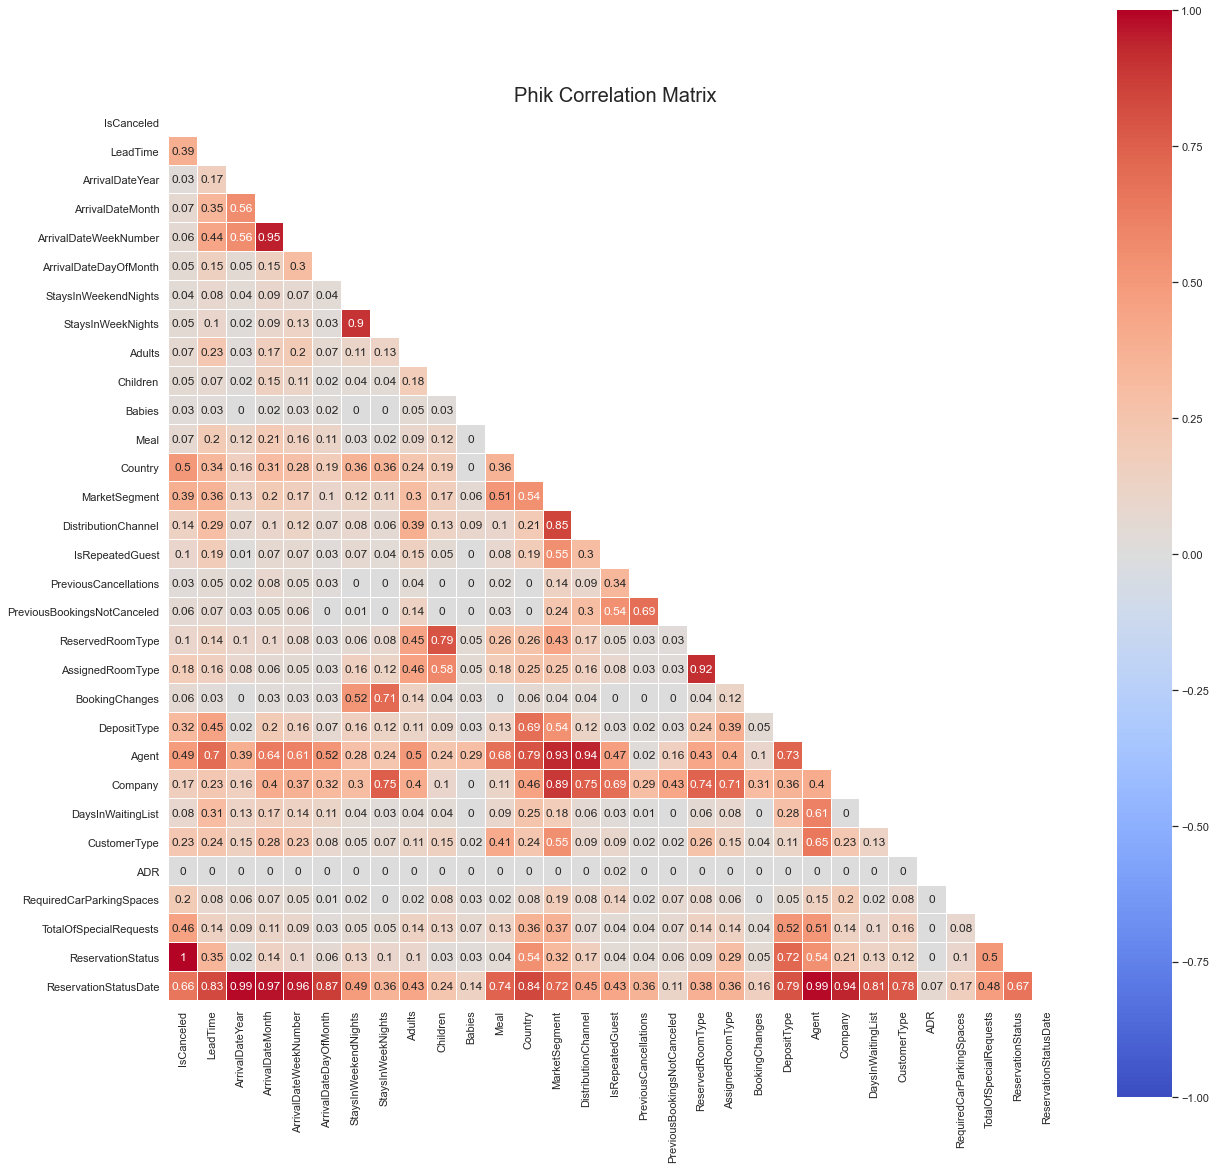

In [13]:
#Proceeding with a Phik Correlation, taking advantage of its ability to be usable for both metric and categorical variables, so we can get an idea of how the variables are correlated.

#Calculating the correlation scores
corr = np.round(data.phik_matrix(), 2)

#adjusting the "output", but only visualizing half the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#Plotting the heatmap/matrix
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 20))
    ax = sns.heatmap(corr, vmin=-1, vmax=1, mask=mask, square=True, linewidths=.2, cmap="coolwarm", annot=True)

#Defing the title
plt.title("Phik Correlation Matrix", fontsize=20)

plt.show()

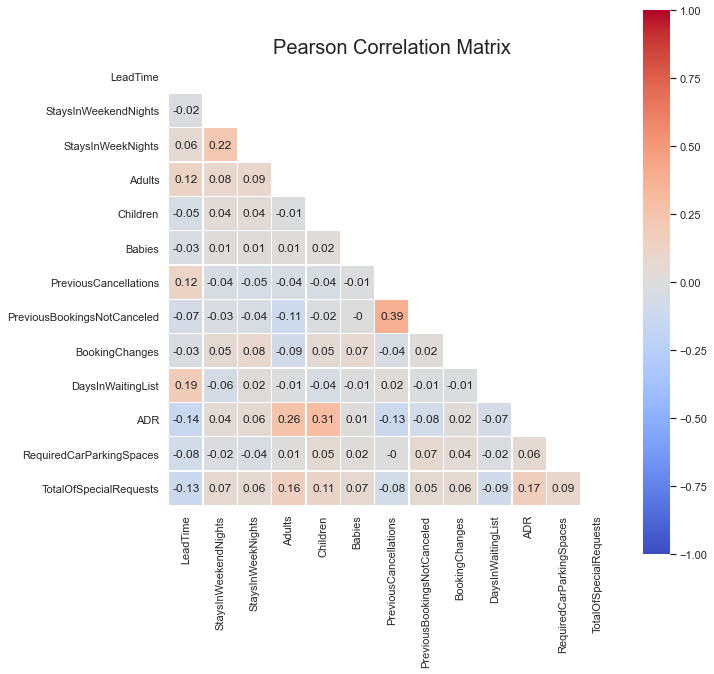

In [14]:
#Now, getting another perspective, using only the metric features, we will analyse the Pearson correlation of the metric features

#Calculating the correlations for the metric features
corr = np.round(data[metric_features].corr(), 2)

#visualizing only half the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#Plotting the matrix/heatmap
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(corr, vmin=-1, vmax=1, mask=mask, square=True, linewidths=.2, cmap="coolwarm",
                     annot=True)

#Defining the title
plt.title("Pearson Correlation Matrix", fontsize=20)
plt.show()

In [15]:
#checking the information shared between the target variable, IsCanceled, and each metric variable, using the mutual information

#Calculating the mutual information score between each metricfeature and the variable IsCanceled
for variable in metric_features:
    print(variable,":", round(mutual_info_classif(np.array(data.dropna()[variable]).reshape(-1, 1), data.dropna()["IsCanceled"])[0], 4))


LeadTime : 0.0963
StaysInWeekendNights : 0.0037
StaysInWeekNights : 0.007
Adults : 0.0127
Children : 0
Babies : 0
PreviousCancellations : 0.0481
PreviousBookingsNotCanceled : 0.0074
BookingChanges : 0.0238
DaysInWaitingList : 0.0166
ADR : 0.0928
RequiredCarParkingSpaces : 0.0106
TotalOfSpecialRequests : 0.0546


### Data Quality Verification

In [16]:
#Checking missing values
data.isnull().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
Agent                           0
Company                         0
DaysInWaitingList               0
CustomerType                    0
ADR                             0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationSta

In [17]:
#Checking duplicated bookings
data.loc[data.duplicated(keep="first"), :]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
9,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
12,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
17,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
18,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
22,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79289,0,186,2017,August,35,31,0,3,2,0.0,...,No Deposit,9,NULL,0,Transient,126.00,0,2,Check-Out,2017-09-03
79292,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79293,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79294,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03


Data Inconsistences/Non interesting customers

In [18]:
#Checking if there is any booking whose ADR is zero.

#In this particular case, Michael told us this happens due to valid reasons and we should therefore be interested in also forecasting this type of booking
data[data["ADR"]==0].shape[0]

1208

In [19]:
#Checking if there are bookings whose StaysinWeekednNights and StaysInWeekNights are both equal to zero, meaning someone did not stay any night

#We were told this represented the customers who only used the Hotel services, and not the room itself. Consequently, this is not relevant for the task at hand.
data[(data["StaysInWeekendNights"]==0) & (data["StaysInWeekNights"]==0)].shape[0]

331

In [20]:
#Checking if there is any booking where a Guest is consedered as Non-Repeated, but has a PreviousCancellation or a previous booking which was not cancelled.
#In this case, this is something which we consider as impossible.

data[((data["IsRepeatedGuest"]==0) & (data["PreviousCancellations"]!=0) & (data["PreviousBookingsNotCanceled"]!=0))].shape[0]

14

In [21]:
#Checking the opposite situation of the previous verification.
#Again, it's considered as an inconsistency.

data[((data["IsRepeatedGuest"]==1) & (data["PreviousCancellations"]==0) & (data["PreviousBookingsNotCanceled"]==0))].shape[0]

296

In [22]:
#Checking if there are any bookings where there are no Adults, no Children and no Babies.
#We were told this happens when a Guest uses only the Hotel services and not a room. Therefore, these bookings are not insteresting for the problem at hand.

data[((data["Adults"]==0) & (data["Children"]==0) & (data["Babies"]==0))].shape[0]

167

## Data Preparation:

### Select data

In [4]:
#creating a copy of our dataset, so we can proceed with the changes needed, while keeping the original dataset unchanged
data_processed=data.copy()

#Dropping the variables ReservationStatus, ReservationStatusDate, AssignedRoomType, BookingChanges and Country, as these represent information which is only obtained after the booking is made (namely, until the check-in time), and therefore is not useful to predict a cancelation as before-hand as possible.
#We were told the variable DepositType was wrongly collected, so we decided to drop it too.
data_processed.drop([ "ReservationStatus","DepositType", "ReservationStatusDate","AssignedRoomType", "BookingChanges", "Country"], axis=1, inplace=True)

#Dropping the variable ArrivalDateWeekNumber due to its high correlation with ArrivalDateMonth, since this last one has less cardinality.
data_processed.drop(["ArrivalDateWeekNumber"], axis=1, inplace=True)

#Dropping the variable ArrivalDateYear, as this variable reflects information which is "one-time only", and is not a characteristic which can be reproduced for other bookings in the future.
data_processed.drop(["ArrivalDateYear"], axis=1, inplace=True)

#Dropping the duplicate bookings. Although we were informed they represent different bookings,considering the potential bias including these entries in any future predictive model would cause.
#data_processed.drop_duplicates(inplace=True)

### Clean data


Noise

In [5]:
#Acting up on the inconsistencies/not interesting entries found earlier and dropping those, while also dropping the missing values, considering they do not represent a sufficient amount to be dealt with.

data_processed = data_processed[~((data_processed["StaysInWeekendNights"]==0) & (data_processed["StaysInWeekNights"]==0))]
data_processed.dropna(inplace=True)
data_processed = data_processed[~((data_processed["IsRepeatedGuest"]==0) & (data_processed["PreviousCancellations"]!=0) & (data_processed["PreviousBookingsNotCanceled"]!=0))]
data_processed = data_processed[~((data_processed["IsRepeatedGuest"]==1) & (data_processed["PreviousCancellations"]==0) & (data_processed["PreviousBookingsNotCanceled"]==0))]
data_processed = data_processed[~((data_processed["Adults"]==0) & (data_processed["Children"]==0) & (data_processed["Babies"]==0))]

#Updating the features' lists
metric_features = [i for i in metric_features if i in data_processed.columns]
categorical_features = [i for i in categorical_features if i in data_processed.columns]

Outliers

In [6]:
#Dealing with the Outliers. We will consider an outlier any entry which is consider one according to both the IQR method (univariate space) and Mahalanobis distance (multivariate space).

#Computing an inverse covariance matrix to calculate the Mahalanobis distance
Inverse_Covariance = sp.linalg.inv(data_processed [metric_features].cov().values)

#Computing the average of each variable
mean_columns = data_processed [metric_features].mean().values

#Defining a function to compute the Mahalanobis distance
def mahalanobis_distances(df,mean_columns,Inverse_Covariance):
    """This function receives a dataframe, an array with the average of its variables and its inverse covariance matrix.
    It returns the distance for each row of the dataframe."""
    
    distances = []
    
    #computing the distances
    for i in range(df.shape[0]):
        distances.append(mahalanobis(df.iloc[i,:],mean_columns,Inverse_Covariance) ** 2)
    
    return(distances)

#Using the mahalanobis_distances function to compute the distances of our dataframe
m_distances = mahalanobis_distances(data_processed[metric_features],mean_columns,Inverse_Covariance)

#Using these distances to check which observations, according with a Chi-squared distribution with a alpha level of 0.05, are considered outliers.
#storing them in the outliers_mahalanobis list
outliers_mahalanobis =[]
for index, distance in enumerate(m_distances):
    if distance > chi2.ppf((1-0.05),df=len(metric_features)-1):
        outliers_mahalanobis.append(data_processed.index.values[index])
        
        
#Defining a function to compute the potential outliers, using the IQR method.
def iqr_method(column):
    """This function returns a tuple with the lower and the upper bonds for a observation in a given column to be considered a potential outlier, according to the IQR method."""
    
    #Computing both the 1st and the 3rd quartiles
    q1,q3 = np.percentile(sorted(column), [25,75])
    
    #computing the lower and the upper bonds
    lower = q1 - (2* (q3 - q1))
    upper = q3 + (2* (q3 - q1))  
    
    return lower,upper

outliers_IQR=[]

#Going through each metric variables and storing in the outliers_IQR list the index of the observations which are beyond the bonds defined.
for var in metric_features:
    lower, upper= iqr_method(data_processed [var])
    if lower == upper:
        lower=upper
    else:
        indexes_outliers=data_processed [(data_processed [var]<lower)|(data_processed [var]>upper)].index.values
        for index in indexes_outliers:
            outliers_IQR.append(index) 

In [7]:
#Defining as outliers the bookings which were considered as outliers by both methods.
index_outliers=[index for index in outliers_mahalanobis if (index in outliers_IQR)]

In [8]:
#Checking how many outliers we found
print("We considered", len(index_outliers), "customers as outliers, which corresponds to", round(len(index_outliers)/data_processed.shape[0]*100,2), "% of the total number of customers.")

We considered 1706 customers as outliers, which corresponds to 2.17 % of the total number of customers.


In [9]:
#Removing them from our data_processed dataframe.
data_processed.drop(index_outliers, axis=0, inplace=True)

### Construct data

Solving high cardinality by changing variables' construction

Company

In [10]:
#For variable Company, we decided to only keep if a booking was made by a Company or not, turining it into a binary variable, due to the distribution found.
data_processed["Company"] = data_processed["Company"].apply(lambda x: "No Company" if x=="       NULL" else "Company")

Agent

In [11]:
#For variable Agent, we decided to keep all the ID's whose frequency was higher than 1.000, Otherwise, we grouped the ID's into a "Others", while keeping the "NULL"
data_processed["Agent"] = data_processed["Agent"].apply(lambda x: "9" if x=='          9' else "NULL" if x=='       NULL' else "7" if x=='          7' else "14" if x=='         14' else "28" if x=='         28' else "8" if x=='          8' else "1" if x=='          1' else "6" if x=='          6' else "3" if x=='          3' else "37" if x=='         37' else "19" if x=='         19' else "Other Agent") 

In [12]:
#cheking that everything is alright.
data_processed["Agent"].value_counts()

9              31015
Other Agent    15509
NULL            7809
1               6863
7               3443
14              3414
6               2653
28              1633
3               1307
37              1228
8               1134
19              1055
Name: Agent, dtype: int64

ArrivalDateDayOfMonth

In [13]:
#For the variable ArrivalDateDayOfMonth, we decided to construct a new variable using it, in conjunction iwth the variable ArrivalDateWeekNumber.
#Intead of having the day of the month each booking was made, we will keep the week of the month.

#Creating an auxiliary dataframe, where we make the bridge between each week of the year and the month and year we are in. 
weeks=pd.DataFrame(data.groupby(["ArrivalDateYear","ArrivalDateMonth"])["ArrivalDateWeekNumber"].unique())

#Auxiliar dictionary
dit={}

#Interating over each week of the year and using the month and year we are in, to assess which week of the month it represents.
for i, lis in enumerate([list(i) for i in weeks["ArrivalDateWeekNumber"].values]):
    for index, value in enumerate(lis):
        dit[str(value)+""+str(weeks.index[i][1])+""+str(weeks.index[i][0])]= "Week_"+str(index+1)
            
#Creating a new variable ArrivalDateWeekOfMonth, by using the information we obtained previously, which is stored in "dit"       
for index in data_processed.index.values:
    year, month, week_nr= data.loc[index,["ArrivalDateYear", "ArrivalDateMonth", "ArrivalDateWeekNumber"]]
    data_processed.loc[index, "ArrivalDateWeekOfMonth"]=dit[str(week_nr)+""+str(month)+""+str(year)]

#Dropping the variable ArrivalDateDayOfMonth    
data_processed.drop("ArrivalDateDayOfMonth", axis=1, inplace=True)

Parking Spaces

In [14]:
data_processed["RequiredCarParkingSpaces"].value_counts()

0    75229
1     1831
3        2
2        1
Name: RequiredCarParkingSpaces, dtype: int64

In [15]:
#For the variable RequiredCarParkingSpaces, due to its distribution of values, we decided to binarized it
data_processed["RequiredCarParkingSpaces"] = data_processed["RequiredCarParkingSpaces"].apply(lambda x: x if x==0 else 1)

Babies

In [16]:
data_processed["Babies"].value_counts()

0     76729
1       329
2         3
9         1
10        1
Name: Babies, dtype: int64

In [17]:
#For the variable Babies, due to its distribution of values, we decided to binarized it
data_processed["Babies"] = data_processed["Babies"].apply(lambda x: x if x==0 else 1)

Verify the data again

In [18]:
#Re-defining the features' lists, according to our changes
metric_features = [i for i in metric_features if i in data_processed.columns] 
metric_features.remove("RequiredCarParkingSpaces")
metric_features.remove("Babies")
categorical_features = [i for i in data_processed.columns if i not in metric_features+["IsCanceled"]] 

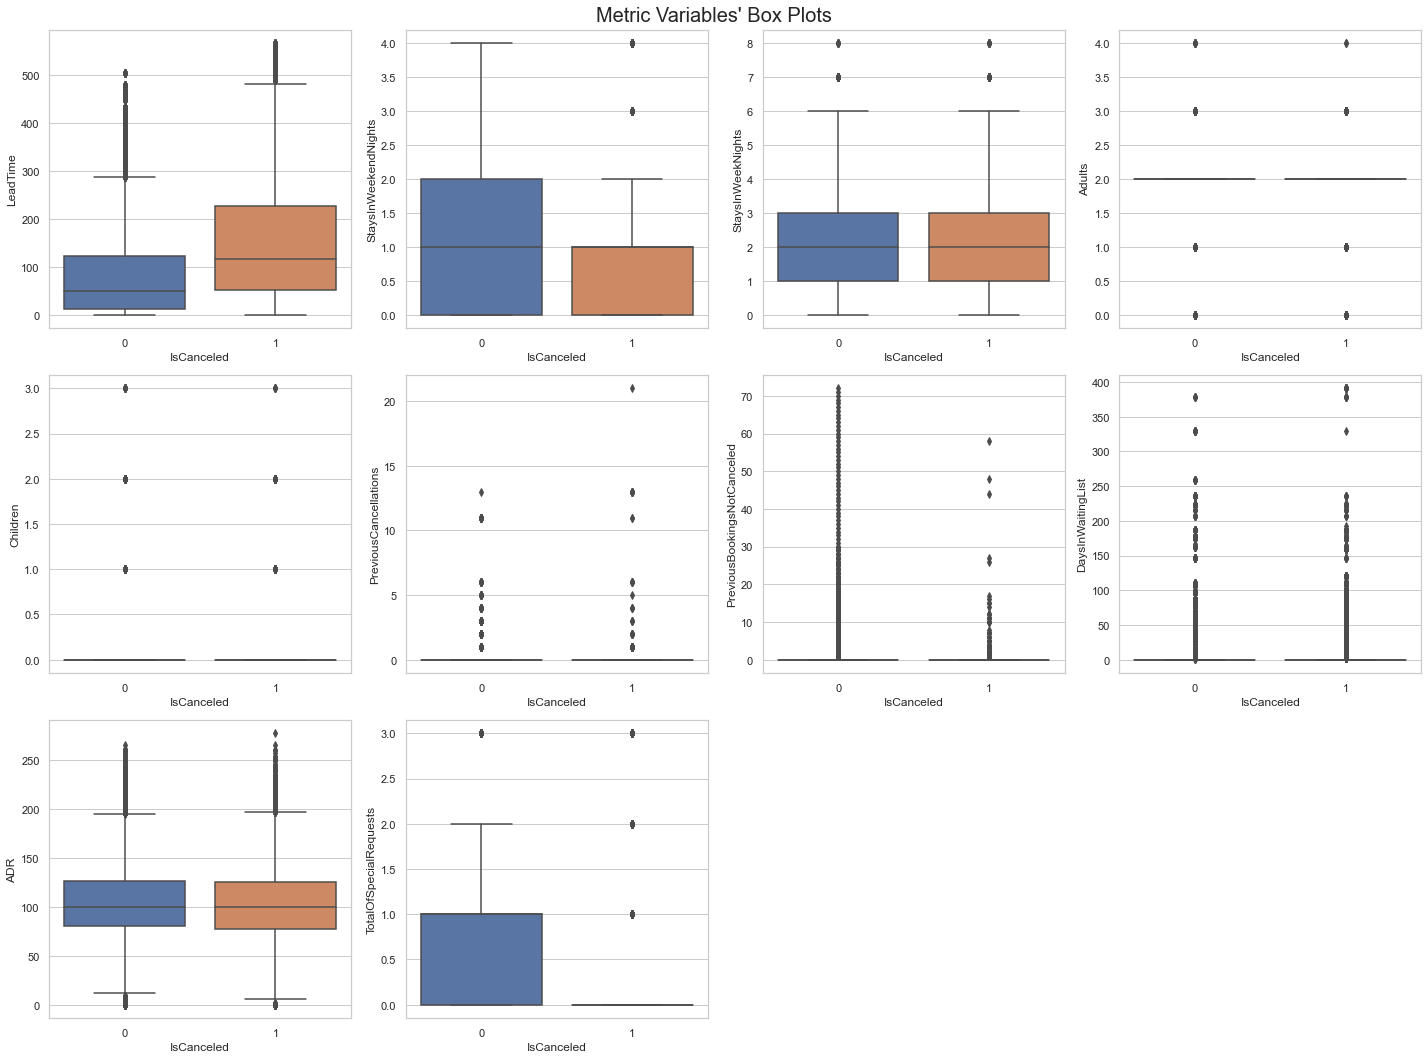

In [38]:
#Plotting boxplots for each metric feature, in order to analyse its distribution, now that some changes were made. Once more, we make the distinction between having Canceled or not.

#changing the background
sns.set()
sns.set_style("whitegrid")

#defining the number of plots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

#plotting each boxplot
for ax, features in zip(axes.flatten(), metric_features):
    sns.boxplot(y=data_processed[features], x=data_processed["IsCanceled"], ax=ax)

#Some layout changes
plt.suptitle("Metric Variables' Box Plots", fontsize=20)
fig.delaxes(axes[2,2])
fig.delaxes(axes[2,3])
plt.tight_layout()

plt.show()

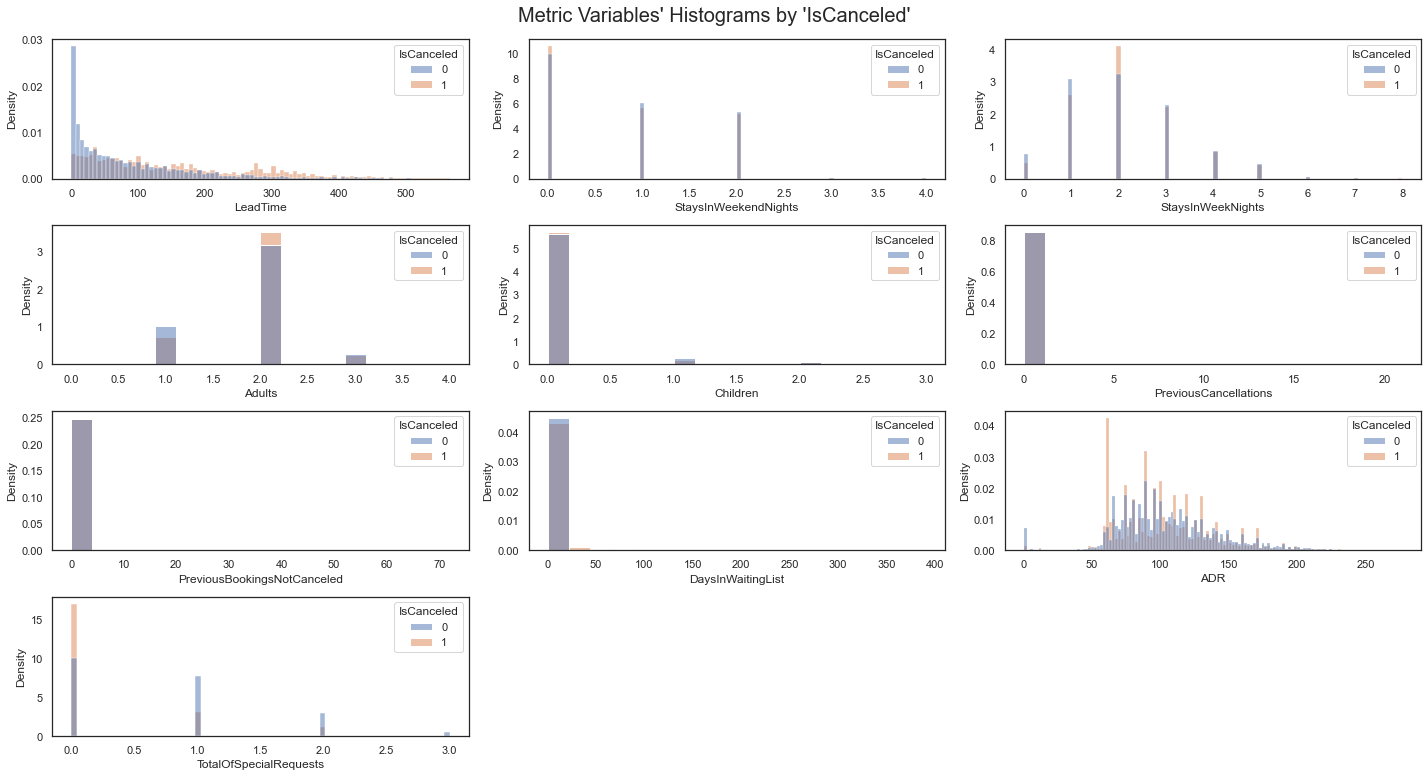

In [39]:
#Plotting again histograms for each metric feature, after the changes made, in order to analyse its distribution from another perspective, while also making the separation between the observations which have 0 or 1 for the variable IsCanceled

#Defining the background
sns.set()
sns.set_style("white")


# Creating the needed number of plots
fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(20, 11))

#Plotting each metric feature, using the "hue" to make the separation according to the variable IsCanceled
for ax, feat in zip(axes.flatten(), metric_features):
    sns.histplot(x=data_processed[feat], hue=data_processed['IsCanceled'], stat='density', common_norm=False, ax=ax)
    
#Defining a title
plt.suptitle("Metric Variables' Histograms by 'IsCanceled'",fontsize=20 )

#Adjusting the "visual" aspect of the plots
plt.subplots_adjust(wspace=0.4)
fig.delaxes(axes[3,1])
fig.delaxes(axes[3,2])
plt.tight_layout()

plt.show()

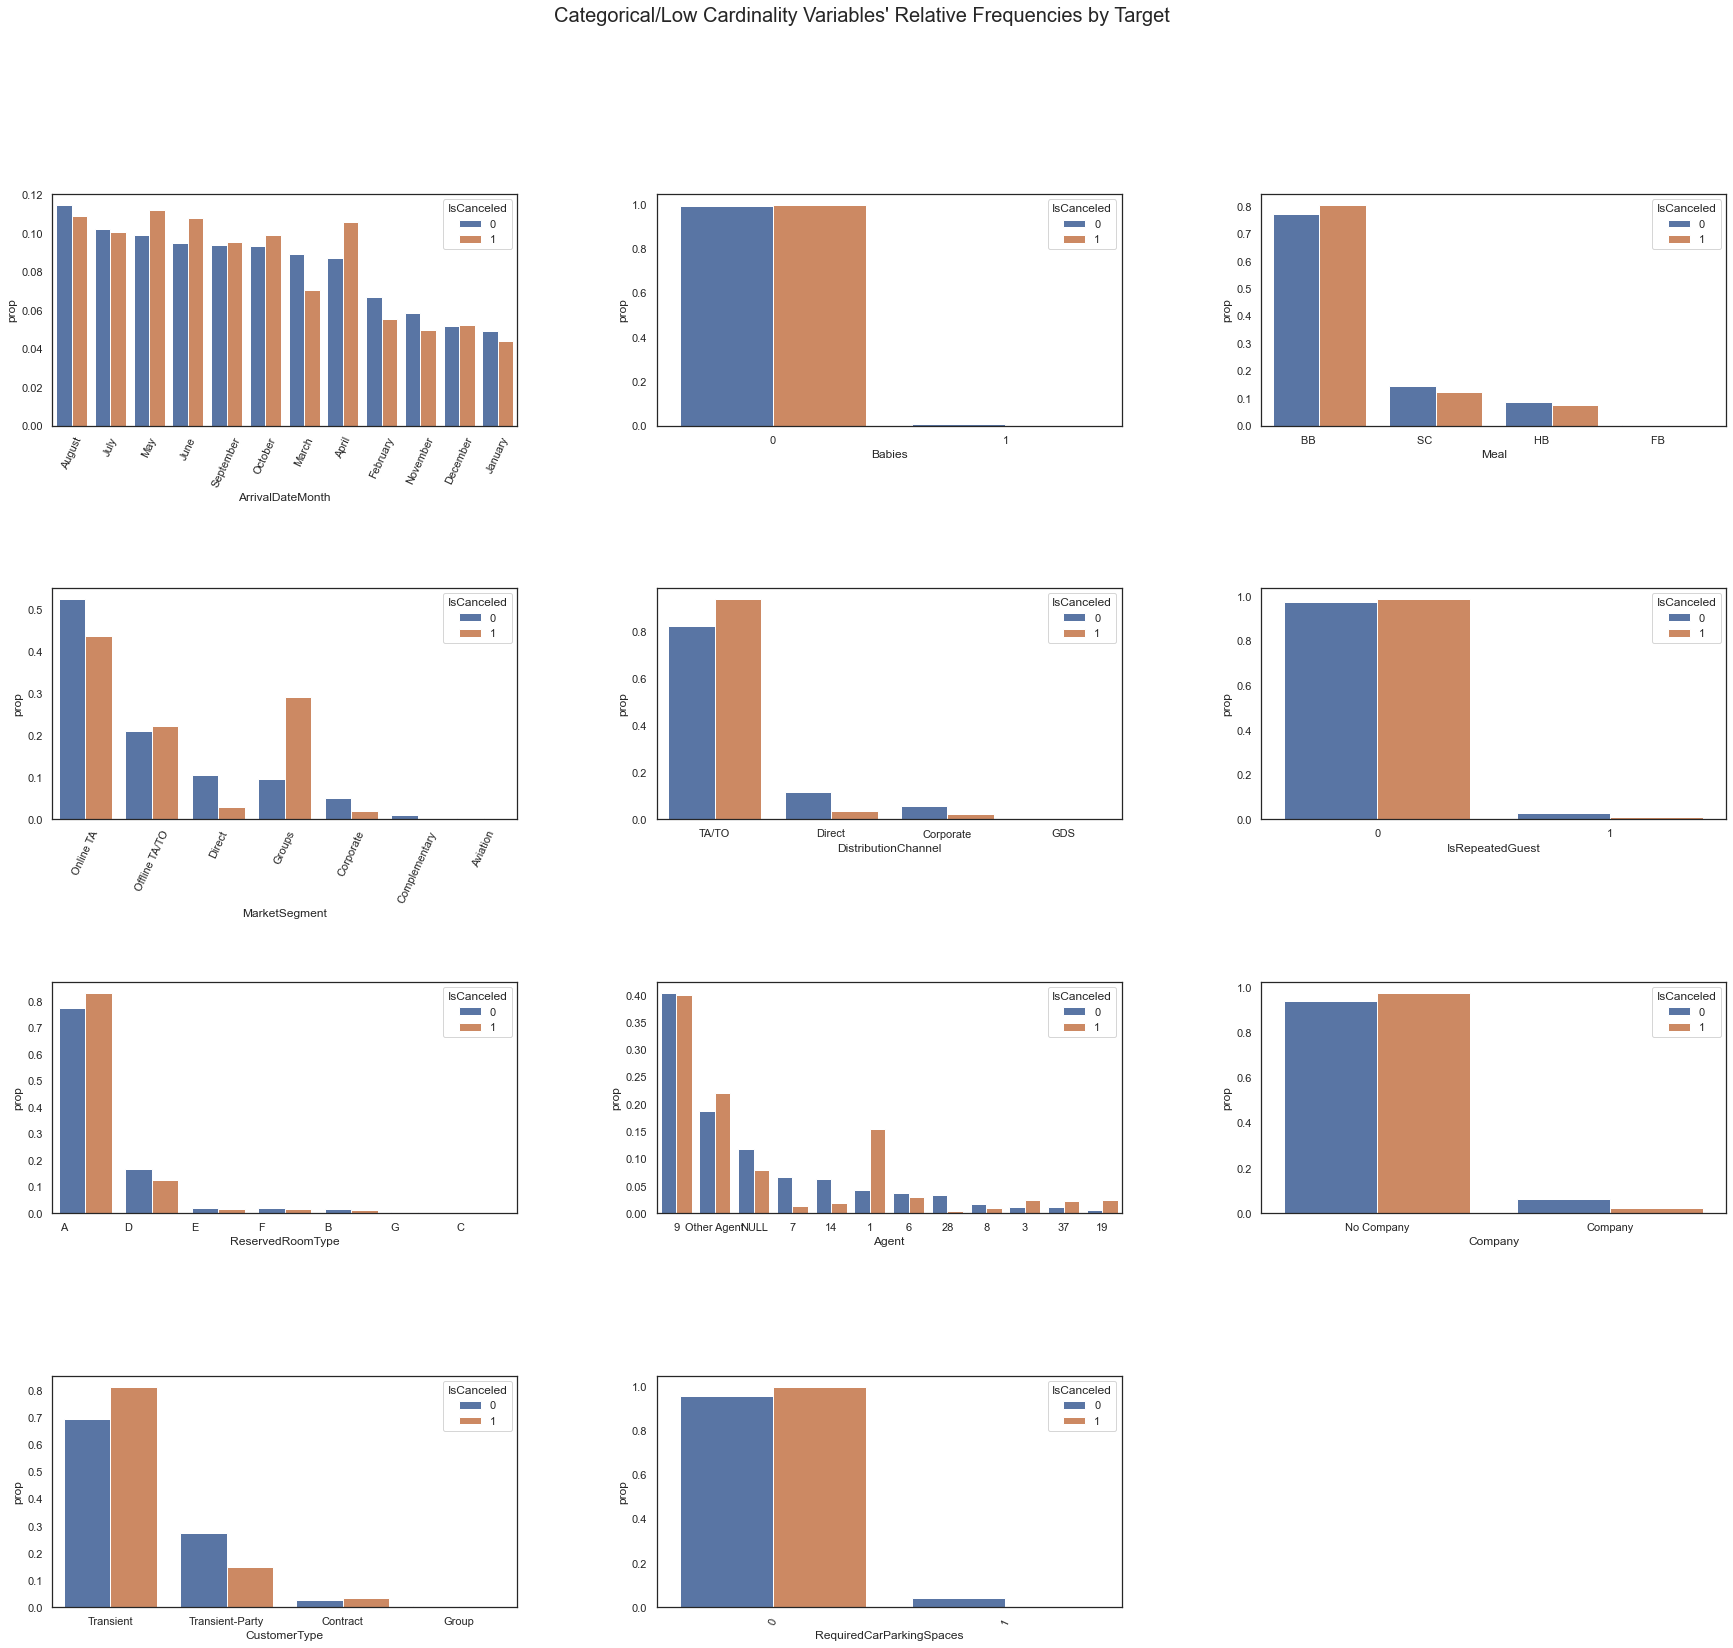

In [40]:
#Now that changes were made, once more, going further in the use of the barplots, by adding the "hue" element, separating between a customer having 0 or 1 in the variable "IsCanceled"

#Defining the background
sns.set()
sns.set_style("white")

#Once more, defining the variables to use 
features = [i for i in categorical_features if i not in ["ReservationStatusDate","Country", "IsCanceled"]]

#choosing teh number of plots
fig, axes = plt.subplots(4, ceil(len(features) / 4), figsize=(30, 26))

#Plotting each barplot
for ax, feat in zip(axes.flatten(), features):
    dt = data_processed.groupby(['IsCanceled'])[feat].value_counts(normalize=True).rename('prop').reset_index()
    sns.barplot(data=dt, x=feat, y='prop', hue='IsCanceled', ax=ax)

#Defining the title
plt.suptitle("Categorical/Low Cardinality Variables' Relative Frequencies by Target", fontsize=20)

#Adjusting the layout
axes.flatten()[-1].remove()
axes.flatten()[0].tick_params(axis='x', labelrotation = 65)
axes.flatten()[3].tick_params(axis='x', labelrotation = 65)
axes.flatten()[10].tick_params(axis='x', labelrotation = 65)
plt.subplots_adjust(wspace=0.3, hspace=0.7)

plt.show()

Encoding categorical features

In [19]:
#We will now proceed to the enconding of the categorical features.

#defining the variables which need to be encoded
encode_features = ["ArrivalDateWeekOfMonth",'ArrivalDateMonth', 'Meal', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType',"Agent", "Company", "CustomerType" ]

#Creating the OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

#Creating a new dataframe, with the variables enconded
data_encoded = pd.DataFrame(encoder.fit_transform(data_processed[encode_features]),
                      index=data_processed.index,
                      columns=encoder.get_feature_names(encode_features))

In [20]:
#Joining the enconded variables in data_enconded with the ones in data_processed
data_processed = pd.concat([data_processed.loc[:, data_processed.columns.drop(encode_features)], data_encoded], axis=1)

In [21]:
#Updating the features' lists
metric_features = [i for i in metric_features if i in data_processed.columns]
categorical_features = [i for i in data_processed.columns if i not in metric_features+["IsCanceled"]]

In [22]:
data_processed.to_excel("data_pro.xlsx")

In [24]:
e=pd.read_excel("data_pro.xlsx")

In [25]:
e.head()

,Unnamed: 0,IsCanceled,LeadTime,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,...,Agent_8,Agent_9,Agent_NULL,Agent_Other Agent,Company_Company,Company_No Company,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party
0,0,0,6,0,2,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,1,1,88,0,4,2,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,2,1,65,0,4,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,3,1,92,2,4,2,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,4,1,100,0,2,2,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


## Modeling

Generate test design

In [ ]:
stopppp

In [44]:
#Separating our data into train and test, keeping 20% for testing purposes
X_train, X_test, y_train, y_test = train_test_split(
    data_processed.drop('IsCanceled', axis=1),
    data_processed['IsCanceled'],
    stratify= data_processed['IsCanceled'],
    test_size=0.2,
    random_state=0)

Creating the model

Withouth duplicates in training set

In [1]:
#Creating a DecisionTreeClassifier instance
dt = DecisionTreeClassifier(random_state=0)

#We will recurr to a GridSearch to tune our model, fiding the best parameters within our pre-selection.
#Defining the parameters and its values, to feed to the GridSearch
grid = {
    "criterion": ["entropy", "gini"],
    "min_samples_leaf": [2,3,4,5],
    "max_depth": [3, 6, 9, 12, 15, None],
    "min_samples_split": [2, 3, 4],
    "max_features": [None, "sqrt", 0.35],
    "class_weight": [None, 'balanced'],
    "ccp_alpha":[0, 0.1,0.01,0.001,0.0001]}

NameError: name 'DecisionTreeClassifier' is not defined

In [46]:
X_train_w=X_train.drop_duplicates()
y_train_w =y_train.loc[X_train_w.index]

In [47]:
#Defining as CV  a statifiedKFold with 5 folds, and using it in our GridSearch, optimized to achieve the best F1 score.
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
gscv = GridSearchCV(dt, grid, cv=splitter, scoring="f1", refit=True, verbose=-1, n_jobs=-1)

In [48]:
#Fitting the train data to the GridSearch
gscv.fit(X_train_w, y_train_w)

#Obtaining the best model
best_dt = gscv.best_estimator_

#Obtaining the predictions to the test and train data according to the model achieved.
y_train_pred_w = best_dt.predict(X_train_w)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 8688 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 10344 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 12144 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 14088 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 16176 tasks  

In [49]:
#Classification Report for the train data
print(classification_report(y_train_w, y_train_pred_w))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81     27378
           1       0.58      0.75      0.66     12271

    accuracy                           0.76     39649
   macro avg       0.73      0.75      0.73     39649
weighted avg       0.78      0.76      0.76     39649



With duplicates

In [50]:
#Creating a DecisionTreeClassifier instance
dt = DecisionTreeClassifier(random_state=0)

#We will recurr to a GridSearch to tune our model, fiding the best parameters within our pre-selection.
#Defining the parameters and its values, to feed to the GridSearch
grid = {
    "criterion": ["entropy", "gini"],
    "min_samples_leaf": [2,3,4,5],
    "max_depth": [3, 6, 9, 12, 15, None],
    "min_samples_split": [2, 3, 4],
    "max_features": [None, "sqrt", 0.35],
    "class_weight": [None, 'balanced'],
    "ccp_alpha":[0, 0.1,0.01,0.001,0.0001]}

In [51]:
#Defining as CV  a statifiedKFold with 5 folds, and using it in our GridSearch, optimized to achieve the best F1 score.
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
gscv = GridSearchCV(dt, grid, cv=splitter, scoring="f1", refit=True, verbose=-1, n_jobs=-1)

In [52]:
#Fitting the train data to the GridSearch
gscv.fit(X_train, y_train)

#Obtaining the best model
best_dt = gscv.best_estimator_

#Obtaining the predictions to the test and train data according to the model achieved.
y_test_pred = best_dt.predict(X_test)
y_train_pred = best_dt.predict(X_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8688 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 10344 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 12144 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 14088 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 16176 tasks  

In [53]:
gscv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight='balanced',
                       criterion='entropy', min_samples_leaf=3, random_state=0)

In [54]:
#Classification Report for the train data
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88     35913
           1       0.83      0.83      0.83     25737

    accuracy                           0.86     61650
   macro avg       0.85      0.85      0.85     61650
weighted avg       0.86      0.86      0.86     61650



In [55]:
#Classification Report for the test data
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      8979
           1       0.79      0.80      0.80      6434

    accuracy                           0.83     15413
   macro avg       0.82      0.83      0.83     15413
weighted avg       0.83      0.83      0.83     15413



In [56]:
#Confusion Matrix for the train data
pd.DataFrame(data=confusion_matrix(y_train, y_train_pred), 
             index=pd.Index(y_test.unique(), name="True"), 
             columns=pd.Index(y_test.unique(), name="Pred"))

Pred,0,1
True,,
0,31381,4532
1,4281,21456


In [57]:
#Confusing matrix for the test data
pd.DataFrame(data=confusion_matrix(y_test, y_test_pred), 
             index=pd.Index(y_test.unique(), name="True"), 
             columns=pd.Index(y_test.unique(), name="Pred"))

Pred,0,1
True,,
0,7637,1342
1,1282,5152


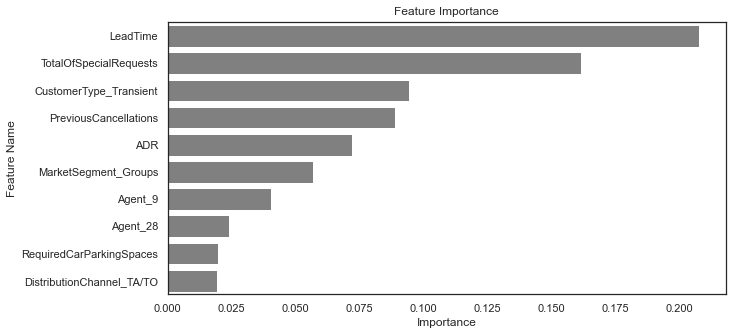

In [58]:
#Seeing which variables are more important to distinguish between the bookings which are canceled or not.

#Defining the background
sns.set()
sns.set_style("white")

plt.figure(figsize=(10,5))

#Storing the feature importance in a dataframe
feature_importance=pd.DataFrame(best_dt.feature_importances_, columns=["Importance"])

#Renaming the columns
feature_importance["Feature Name"]=data_processed.drop("IsCanceled", axis=1).columns

#sorting by descending order
feature_importance.sort_values(by="Importance", ascending = False, inplace = True)

#plotting it
plt.title("Feature Importance", y=1.005)
sns.barplot(y='Feature Name', x='Importance', data=feature_importance.iloc[:10,:], color = "grey")
plt.show()

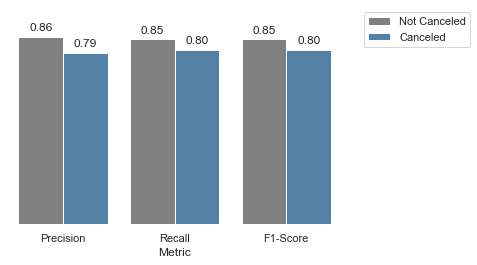

In [59]:
#Plotting the values obtained for Precision, Recall and F1-Score

#Creating an auxliar dataframe with the values of our metrics
df_aux=pd.DataFrame([0.86,0.85,0.85,0.79,0.8,0.8], columns=["Value"])

#Making the correct association with the metric and the label for the target variable
df_aux["Metric"]=["Precision", "Recall", "F1-Score", "Precision", "Recall", "F1-Score"]
df_aux["Cancelled"]=["Not Canceled", "Not Canceled", "Not Canceled", "Canceled", "Canceled", "Canceled"]

#Defining the background
sns.set()
sns.set_style("white")

#Plotting it
graph=sns.barplot(data=df_aux, x="Metric", y='Value', hue='Cancelled', palette=["Grey", "SteelBlue"])

#Adjusting the layout
plt.legend(bbox_to_anchor=(1.4, 1))
plt.ylabel("")
plt.ylim([0,1])
plt.box(False)
plt.yticks([])

#Making the values visible on top of the bars
for p in graph.patches:
    graph.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0.2, 9.3), 
                   textcoords = 'offset points')

plt.show()

In [60]:
#Obtaining the F1 Score of our model, for the test data
f1_score(y_test, y_test_pred)

0.7970297029702971

In [61]:
#Obtaining the Precision Score of our model, for the test data
precision_score(y_test, y_test_pred)

0.7933477055743764

In [62]:
#Obtaining the Recall Score of our model, for the test data
recall_score(y_test, y_test_pred)

0.8007460366801368

[]

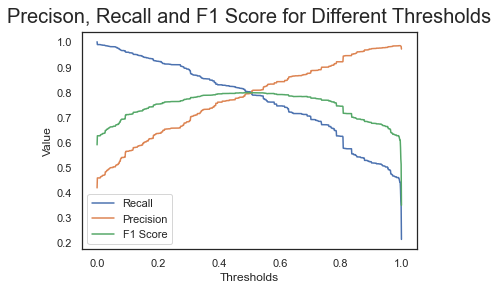

In [63]:
#Auxiliar dictionaries
re={}
pre={}
f1={}

#Calculating for each threshold the values for each metric and storing in the corresponding dictionary
for threshold in np.linspace(0, 1, 1000):
    y_test_pred = (best_dt.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    re[threshold]=recall_score(y_test, y_test_pred)
    pre[threshold]=precision_score(y_test, y_test_pred)
    f1[threshold]=f1_score(y_test, y_test_pred)
    
    

#defing the background
sns.set()
sns.set_style("white")

#Turing the dictionaries into a dataframe
re_df=pd.DataFrame(re.values(), columns=["Recall"], index=re.keys())
pre_df=pd.DataFrame(pre.values(), columns=["Precision"], index=pre.keys())
f1_df=pd.DataFrame(f1.values(), columns=["F1 Score"], index=f1.keys())
values=pd.concat([re_df,pre_df,f1_df], axis=1)


#Plotting it
plt.plot(values.index,values["Recall"], label="Recall")
plt.plot(values.index, values["Precision"],label="Precision")
plt.plot(values.index,values["F1 Score"], label="F1 Score")
plt.legend(loc="lower left")
plt.title("Precison, Recall and F1 Score for Different Thresholds", fontsize=20, y=1.02)
plt.xlabel("Thresholds")
plt.ylabel("Value")
plt.plot()

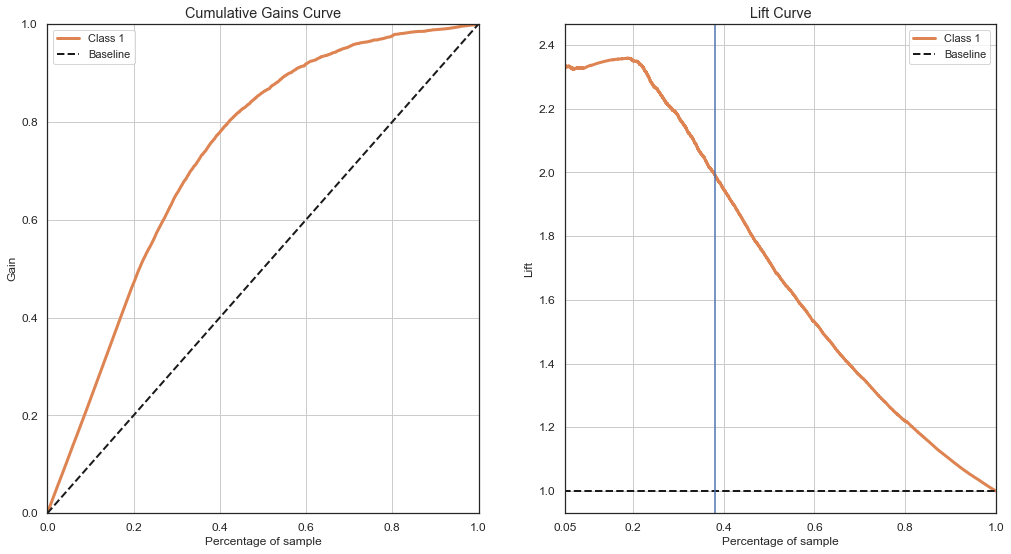

In [64]:
#Plotting the Cumulative Gains and Lift curves

#getting the probabilities of our model
predicted_probas = best_dt.predict_proba(X_test)

#defining the background
sns.set()
sns.set_style("white")

#Creating a plot and plotting both curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 9))
plot_cumulative_gain(y_test, predicted_probas, ax=ax1)
plot_lift_curve(y_test, predicted_probas, ax=ax2)  

#chaning some aspects regarding the graphs
ax2.set_xlim(0.05, 1)
ax2.set_xticks([0.05, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_xticklabels([0.05, 0.2, 0.4, 0.6, 0.8, 1.0])
for ax in (ax1, ax2):
    ax.axes.lines[0].remove()
    ax.get_legend().remove()
    ax.legend()
plt.axvline(x=0.38)
plt.show()

In [65]:
#Checking how many observations represent 25% of our total.
y_test.shape[0]*0.25

3853.25

In [66]:
#Checking which is the threshold from which we are contacting 25% of the customers.
#To contact around 25% of our customers, we would be contacting all with a threshold around 0.66
np.sort(predicted_probas[:, 1])[-3854:]

array([0.83626591, 0.83626591, 0.83626591, ..., 1.        , 1.        ,
       1.        ])

In [67]:
#Defining the 0. as the new threshold for classifying a booking as Canceled
y_test_pred = (best_dt.predict_proba(X_test)[:,1] >= 0.836).astype(bool) 

In [68]:
#Confusion Matrix for the test data
pd.DataFrame(data=confusion_matrix(y_test, y_test_pred), 
             index=pd.Index(y_test.unique(), name="True"), 
             columns=pd.Index(y_test.unique(), name="Pred"))

Pred,0,1
True,,
0,8763,216
1,2745,3689


In [69]:
#checking what percentage of cancellations we would get if contacting only 25% of the customer base
recall_score(y_test, y_test_pred)

0.5733602735467828

In [70]:
#Confirm the actual percentage of the total sample reached
count=0
for i in best_dt.predict_proba(X_test)[:,1]:
    if i  >= 0.836:
        count+=1
print(count/y_test.shape[0])

0.25335755531045223
